In [1]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
%matplotlib inline

In [2]:
df = pd.read_csv("president_polls.csv")

parse_date = lambda date_str: dt.strptime(date_str, '%m/%d/%y')
df["end_date"] = df["end_date"].apply(parse_date)
df = df.sort_values(by="end_date")
df["state"] = df["state"].fillna("National")
df["pct"] = df["pct"]/100

In [3]:
random_walk_var = 0.03**2 # daily variance
start_date = "2024-07-21"
date_range = pd.date_range("2024-07-21", dt.today())

In [4]:
polling_dfs = {}
polls_dfs = {}
for state in df[df["candidate_name"]=="Kamala Harris"]["state"].unique():
    slice_df_harris = df[(df["candidate_name"]=="Kamala Harris") & (df["state"]==state)]
    # slice_df_harris = slice_df_harris[slice_df_harris["end_date"]>"2024-06-21"]

    slice_df_trump = df[(df["candidate_name"]=="Donald Trump") & (df["state"]==state)]
    # slice_df_trump = slice_df_trump[slice_df_trump["end_date"]>"2024-06-21"]

    polling_averages = pd.DataFrame({"date":date_range,"harris_mean":np.nan,"harris_var":np.nan,"trump_mean":np.nan,"trump_var":np.nan})
    polling_averages.set_index("date",inplace=True)

    for date in date_range:
        up_to_date_polls_harris = slice_df_harris[slice_df_harris["end_date"]<=date][["end_date","sample_size","pct"]].copy()
        if up_to_date_polls_harris.shape[0]==0:
            continue
        up_to_date_polls_harris["sample_size"].fillna(500,inplace=True)
        up_to_date_polls_harris["sample_var"] = up_to_date_polls_harris["pct"] * (1 - up_to_date_polls_harris["pct"]) / up_to_date_polls_harris["sample_size"] # Variance due to the sample size
        up_to_date_polls_harris["bias_var"] = 0.03**2 # Variance due to unkown bias (assume mean zero but posses 0.03 var)
        up_to_date_polls_harris["time_since_var"] = (date - up_to_date_polls_harris["end_date"]).dt.days * random_walk_var
        up_to_date_polls_harris["total_var"] = np.clip((up_to_date_polls_harris["sample_var"] + up_to_date_polls_harris["bias_var"] + up_to_date_polls_harris["time_since_var"]),0,1/4)

        polling_averages.loc[date,"harris_mean"] = np.average(up_to_date_polls_harris["pct"],weights= 1 / up_to_date_polls_harris["total_var"])
        polling_averages.loc[date,"harris_var"] = 1 / sum( 1 / up_to_date_polls_harris["total_var"])

    averages_trump = np.array([],dtype=float)
    vars_trump = np.array([],dtype=float)
    for date in date_range:
        up_to_date_polls_trump = slice_df_trump[slice_df_trump["end_date"]<=date][["end_date","sample_size","pct"]].copy()
        up_to_date_polls_trump["sample_size"].fillna(500,inplace=True)
        up_to_date_polls_trump["sample_var"] = up_to_date_polls_trump["pct"] * (1 - up_to_date_polls_trump["pct"]) / up_to_date_polls_trump["sample_size"] # Variance due to the sample size
        up_to_date_polls_trump["bias_var"] = 0.03**2 # Variance due to unkown bias (assume mean zero but posses 0.03 var)
        up_to_date_polls_trump["time_since_var"] = (date - up_to_date_polls_trump["end_date"]).dt.days * random_walk_var
        up_to_date_polls_trump["total_var"] = np.clip((up_to_date_polls_trump["sample_var"] + up_to_date_polls_trump["bias_var"] + up_to_date_polls_trump["time_since_var"]),0,1/4)

        polling_averages.loc[date,"trump_mean"] = np.average(up_to_date_polls_trump["pct"],weights= 1 / up_to_date_polls_trump["total_var"])
        polling_averages.loc[date,"trump_var"] = 1 / sum( 1 / up_to_date_polls_trump["total_var"])
    polling_dfs[state] = polling_averages.copy()

    polls_dfs[state] = pd.merge(up_to_date_polls_harris, up_to_date_polls_trump, on='end_date', how='outer', suffixes=('_harris', '_trump')).sort_values(by='end_date')
    polls_dfs[state].to_csv(f"polling_polls/{state}.csv",index=False)


    polling_averages.to_csv(f"polling_averages/{state}.csv",index=True)
err = sum((polls_dfs[state][polls_dfs[state]["end_date"]>start_date][["end_date","pct_harris"]].dropna().apply(lambda row: row["pct_harris"] - polling_dfs[state]["harris_mean"].loc[row["end_date"]], axis=1))**2) + sum((polls_dfs[state][polls_dfs[state]["end_date"]>start_date][["end_date","pct_trump"]].dropna().apply(lambda row: row["pct_trump"] - polling_dfs[state]["trump_mean"].loc[row["end_date"]], axis=1))**2)


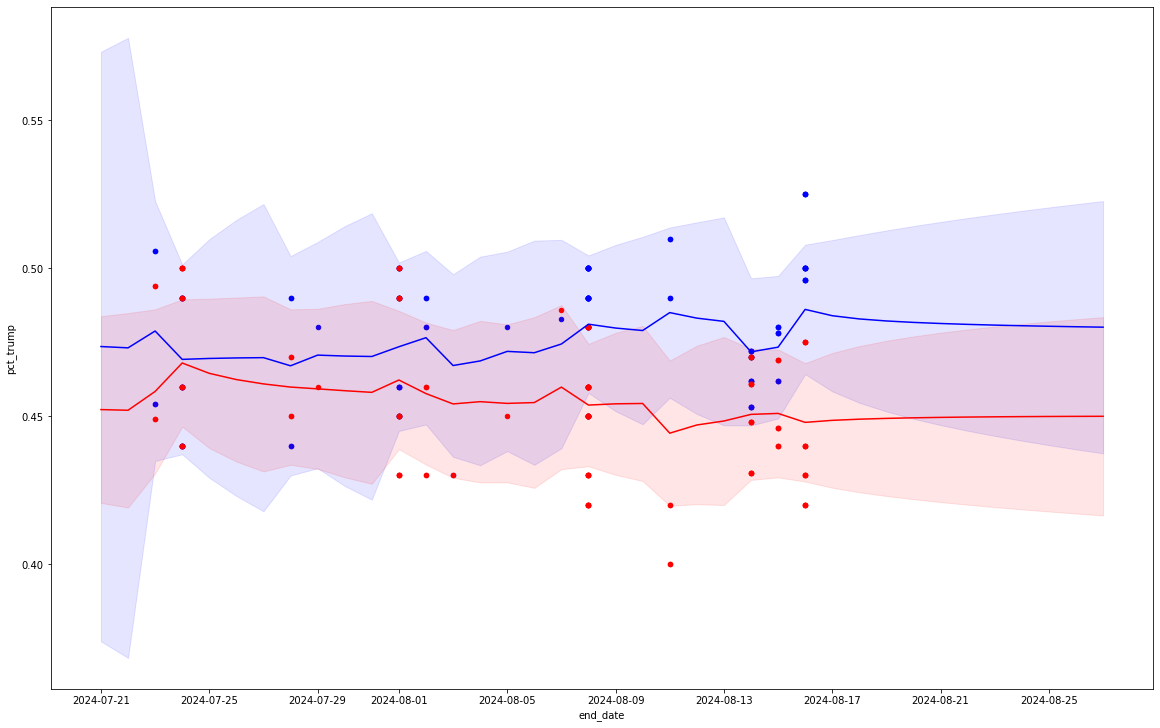

In [5]:
state = "Wisconsin"
fig, ax = plt.subplots(figsize=(16,10),layout='constrained')
polls_dfs[state][polls_dfs[state]["end_date"]>start_date].plot.scatter(x="end_date",y="pct_harris",ax=ax,c='blue')
ax.plot(date_range,polling_dfs[state]["harris_mean"],color="blue")
ax.fill_between(date_range, polling_dfs[state]["harris_mean"]-1.96*np.sqrt(polling_dfs[state]["harris_var"]), polling_dfs[state]["harris_mean"]+1.96*np.sqrt(polling_dfs[state]["harris_var"]), color='blue', alpha=.1)

polls_dfs[state][polls_dfs[state]["end_date"]>start_date].plot.scatter(x="end_date",y="pct_trump",ax=ax,c='red')
ax.plot(date_range,polling_dfs[state]["trump_mean"],color="red")
ax.fill_between(date_range, polling_dfs[state]["trump_mean"]-1.96*np.sqrt(polling_dfs[state]["trump_var"]), polling_dfs[state]["trump_mean"]+1.96*np.sqrt(polling_dfs[state]["trump_var"]), color='red', alpha=.1)


In [6]:
polling_dfs[state]["harris_var"] + polling_dfs[state]["trump_var"]

date
2024-07-21    0.002841
2024-07-22    0.003137
2024-07-23    0.000701
2024-07-24    0.000388
2024-07-25    0.000589
2024-07-26    0.000766
2024-07-27    0.000929
2024-07-28    0.000537
2024-07-29    0.000571
2024-07-30    0.000724
2024-07-31    0.000858
2024-08-01    0.000353
2024-08-02    0.000374
2024-08-03    0.000410
2024-08-04    0.000517
2024-08-05    0.000481
2024-08-06    0.000590
2024-08-07    0.000522
2024-08-08    0.000252
2024-08-09    0.000355
2024-08-10    0.000439
2024-08-11    0.000372
2024-08-12    0.000459
2024-08-13    0.000531
2024-08-14    0.000288
2024-08-15    0.000272
2024-08-16    0.000229
2024-08-17    0.000305
2024-08-18    0.000367
2024-08-19    0.000422
2024-08-20    0.000473
2024-08-21    0.000520
2024-08-22    0.000564
2024-08-23    0.000607
2024-08-24    0.000648
2024-08-25    0.000688
2024-08-26    0.000727
2024-08-27    0.000765
dtype: float64

In [7]:
np.sqrt(0.001081)

0.032878564445547195